# Differential gene expression

One of the most commonly asked questions when comparing between conditions is which genes
are differentially expressed. In statistical terms, we ask if the mean gene expression differs between two groups more than what would be expected by random chance.
A common fallacy here is that frequently applied statistical tests assume independence of the observations, while cells from the same sample or patient are not independent. This is also called "pseudoreplication bias" and leads to drastically inflated p-values {cite}`squairConfrontingFalseDiscoveries2021, zimmermanPracticalSolutionPseudoreplication2021`.

Unfortunately, the differential testing
functions available from the most commonly used frameworks (e.g. {func}`scanpy.tl.rank_genes_groups` in scanpy) do not account for this, allowing for qualitative comparisons at best. As an alternative, {cite:t}`squairConfrontingFalseDiscoveries2021` suggest to aggregate samples into "pseudo-bulks" and apply tools originally designed for comparing bulk RNA-seq samples.

In this section, we are going to demonstrate how to generate pseudo-bulk samples by cell-type using
[decoupler](https://github.com/saezlab/decoupler-py) {cite}`badia-i-mompelDecoupleREnsembleComputational2022` and apply DESeq2 {cite}`loveModeratedEstimationFold2014` to perform cell-type-specific comparison between conditions.

:::{seealso}
 * The [Differential gene expression](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) chapter of the single-cell best practice book {cite}`heumosBestPracticesSinglecell2023`.
 * The [decoupler pseudobulk vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html).
:::

## 1.Load libraries

In [1]:
%load_ext autoreload
%autoreload 2
import re
import subprocess as sp
from pathlib import Path

import decoupler as dc
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from anndata import AnnData
from tqdm.contrib.concurrent import process_map

import atlas_protocol_scripts as aps

## 2. Load input data
1. Load the annotated AnnData object

In [2]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
adata = sc.read_h5ad(adata_path)

2. Define the paths to the scripts for DESeq2. The script is shipped as part of the `atlas_protocol` repo.

In [3]:
deseq_script_path = "../../bin/deseq2.R"

3. Create output directories

In [4]:
deseq_results = Path("../../data/results/differential_expression/")
!mkdir -p {deseq_results}

View of AnnData object with n_obs × n_vars = 25892 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'cell_type', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'cell_type_major', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_cell_type_tumor_predicted_colors', '_scvi', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_major_colors', 'cell_type_predicted_colors', 'cell_type_tumor_colors', 'condition_colors', 'dataset_colors', 'doublet_status_color

## 3. Generate Pseudobulk

Here, we aggregate counts by biological replicate (patient) for each cell-type individually.

1. subset AnnData to the cells of interest. In this case, we only focus on cells originating from primary tumor samples and the two conditions (LUAD vs. LUSC) we are going to compare.

In [5]:
adata = adata[adata.obs["origin"].isin(["tumor_primary"]) & adata.obs["condition"].isin(["LUAD", "LUSC"])]
adata

AnnData object with n_obs × n_vars = 22 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'psbulk_props'

2. Generate pseudobulk

:::{important}
Generate pseudo-bulk based on **raw counts** and aggregate them by summing up.
:::

In [6]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col="sample",
    groups_col=["cell_type_coarse", "condition"],
    layer="raw_counts",  # layer where raw counts are store in adata
    mode="sum",
    min_cells=0,  # we are setting this to 0 and filter in an explicit, separate step.
    min_counts=0,
)
pdata

3. Inspect the table of "pseudobulk samples"

In [7]:
pdata.obs

AnnData object with n_obs × n_vars = 22 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'psbulk_props', 'counts'

## 4. Filter samples

In this step, we are removing samples that consist of too few cells or have a small number of total counts in both conditions.

1. Plot relationship of counts and cells per dataset and cell-type

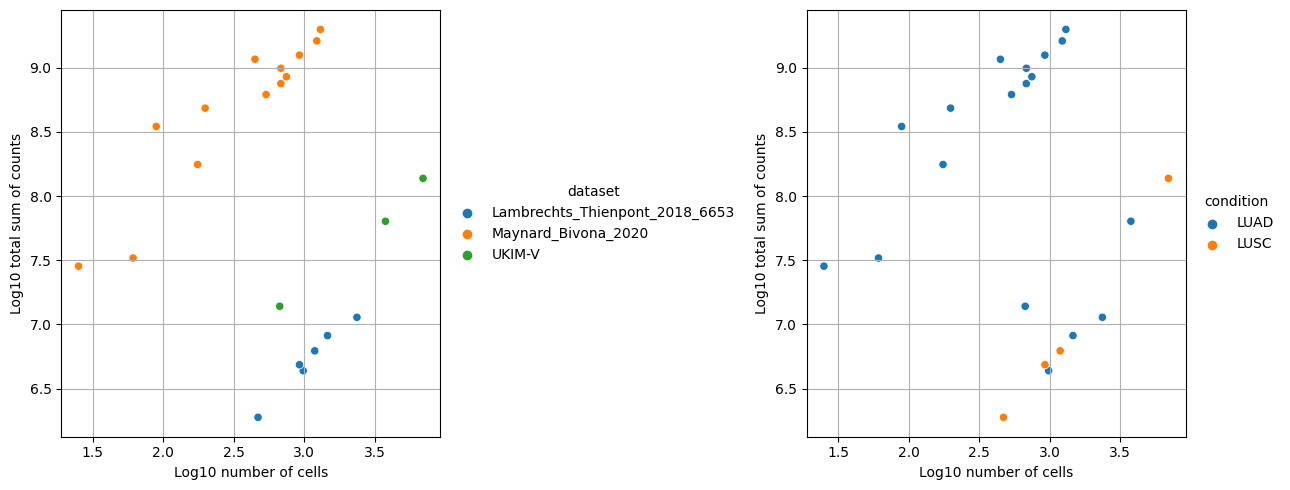

In [8]:
for col in ["dataset", "cell_type_coarse", "condition"]:
    dc.plot_psbulk_samples(pdata, groupby=col, figsize=(3, 3))

2. Remove samples with less than 10 cells or less than 1000 counts

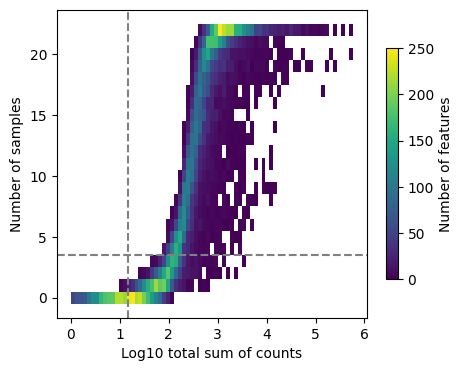

In [9]:
pdata = pdata[(pdata.obs["psbulk_n_cells"] >= 10) & (pdata.obs["psbulk_counts"] >= 1000)]

## 5. Split pseudobulk by cell-type

For the following steps, we treat each cell-type separately, therefore we split the pseudobulk object
into a dictionary of objects per cell-type.

1. Define list of cell-types

In [10]:
cell_types = pdata.obs["cell_type_coarse"].unique()

2. Generate per-cell-type dictionary

In [ ]:
pdata_by_cell_type = {}
for ct in cell_types:
    pb = pdata[pdata.obs["cell_type_coarse"] == ct, :].copy()
    if pb.obs["condition"].nunique() <= 1:
        print(f"Cell type {ct} does not have samples in all groups")
    else:
        pdata_by_cell_type[ct] = pb

## 6. Filter genes
Here, we filter noisy genes with a low expression value. We remove genes that do not have a certain number of total counts (`min_total_count`) and have a minimum number of counts in at least $n$ samples, where $n$ equals to the number of samples
in the smallest group (or less, if there is a sufficient number of samples).

This needs to be done for each cell-type individually since each
cell-type may express different sets of genes.

:::{seealso}
[`filterByExpr`](https://rdrr.io/bioc/edgeR/man/filterByExpr.html) in [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html).
:::

1. Inspect, for a given cell-type, the number of genes that the thresholds (here for Epithelial cells):

In [ ]:
dc.plot_filter_by_expr(
    pdata_by_cell_type["Epithelial cell"],
    group="condition",
    min_count=10,
    min_total_count=15,
)

2. Apply filter genes for all cell-types. Here, we apply the same (default) filter to all cell-types.

In [ ]:
for tmp_pdata in pdata_by_cell_type.values():
    dc.filter_by_expr(
        tmp_pdata,
        group="condition",
        min_count=10,
        min_total_count=15,
    )

## 7. Run DESeq

1. Inspect the help page of the DESeq2 script

In [ ]:
!{deseq_script_path} --help

2. Define a function to create an output directory per cell-type

In [ ]:
def _create_prefix(cell_type):
    ct_sanitized = re.sub("[^0-9a-zA-Z]+", "_", cell_type)
    prefix = deseq_results / "LUAD_vs_LUSC" / ct_sanitized
    prefix.mkdir(parents=True, exist_ok=True)
    return prefix

2. Export pseudobulk objects to CSV files. This will generate a count matrix an a samplesheet for each cell-type.

In [ ]:
for ct, tmp_pdata in pdata_by_cell_type.items():
    prefix = _create_prefix(ct)
    aps.io.write_deseq_tables(tmp_pdata, prefix / "samplesheet.csv", prefix / "counts.csv")

3. Execute the DESeq2 script

:::{important}
Always specify at least `dataset` as a covariate when performing differential expression analysis,
to account for batch effects.

It may make sense to include other covariates (sex, tumor stage, age, ...) into the model
depending on your dataset and research question.
:::

In [ ]:
def _run_deseq(cell_type: str, pseudobulk: AnnData):
    """Function: Run DESeq2 on pseudobulk of all cell types from cell_type."""
    prefix = _create_prefix(cell_type)
    # fmt: off
    deseq_cmd = [
        deseq_script_path, prefix / "counts.csv", prefix / "samplesheet.csv",
        "--cond_col", "condition",
        "--c1", "LUAD",
        "--c2", "LUSC",
        "--covariate_formula", "+ dataset + sex",
        "--resDir", prefix,
        "--prefix", prefix.stem,
    ]
    # fmt: on
    with open(prefix / "out.log", "w") as stdout:
        with open(prefix / "err.log", "w") as stderr:
            sp.run(
                deseq_cmd,
                capture_output=False,
                stdout=stdout,
                stderr=stderr,
                check=True,
            )


_ = process_map(_run_deseq, pdata_by_cell_type, pdata_by_cell_type.values())

4. import results

In [ ]:
de_results = {}
for ct in pdata_by_cell_type:
    prefix = _create_prefix(ct)
    de_results[ct] = pd.read_csv(prefix / f"{prefix.stem}_DESeq2_result.tsv", sep="\t").assign(cell_type=ct)

## 8. Make volcano plots

1. Convert DE results to p-value/logFC matrices as used by decoupler

In [ ]:
logFCs, pvals = aps.tl.long_form_df_to_decoupler(pd.concat(de_results.values()), p_col="padj")

2. Make a volcano plot for all cell-types of interest (e.g. B cells)

In [ ]:
fig, ax = plt.subplots()
dc.plot_volcano(logFCs, pvals, "B cell", name="B cell", top=10, sign_thr=0.1, lFCs_thr=0.5, ax=ax)
ax.set_ylabel("-log10(FDR)")
ax.set_xlabel("log2(FC)")
fig.show()

4. Normalize pseudobulk to log counts per million (logCPM)

## 9. Plot genes of interest as paired dotplots

Here, we are visualizing the actual expression values for each sample for all genes and cell-types of interest

1. Define list of genes to visualize

In [ ]:
genes = ["EIF1AY", "GSTM1", "XIST", "MYRF"]

2. Normalize pseudobulk to counts per million (CPM)

In [11]:
for tmp_pdata in pdata_by_cell_type.values():
    sc.pp.normalize_total(tmp_pdata, target_sum=1e6)
    sc.pp.log1p(tmp_pdata)

3. Make plot (e.g. B cells)

In [12]:
# Get p-values for genes of interest
tmp_pvalues = de_results["B cell"].set_index("gene_id").loc[genes, "padj"].values

aps.pl.plot_paired(
    pdata_by_cell_type["B cell"],
    groupby="condition",
    var_names=genes,
    hue="dataset",
    ylabel="log(CPM+1)",
    panel_size=(2, 4),
    pvalues=tmp_pvalues,
    pvalue_template=lambda x: f"DESeq2 FDR={x:.3f}",
)